# Установка необходимых инструментов

In [ ]:
!pip install pyspark
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=281983e99f17995f6be5523fe282edae5dbea13743dc83b6ae53f156d515d707
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.8 MB/s eta 0:00:00


# Импорт необходимых библиотек

In [ ]:
import csv
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from faker import Faker
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, to_date, sum as _sum

# Генерация данных

In [ ]:
fake = Faker()

num_records = 100000

http_methods = ['GET', 'POST', 'PUT', 'DELETE']
response_codes = [200, 301, 404, 500]

file_path = "web_server_logs.csv"

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ip', 'timestamp', 'method', 'url', 'response_code', 'response_size'])

    for _ in range(num_records):
        ip = fake.ipv4()
        timestamp = fake.date_time_this_year().isoformat()
        method = random.choice(http_methods)
        url = fake.uri_path()
        response_code = random.choice(response_codes)
        response_size = random.randint(100, 10000)

        writer.writerow([ip, timestamp, method, url, response_code, response_size])

print(f"Сгенерировано {num_records} записей и сохранено в {file_path}")

Сгенерировано 100000 записей и сохранено в web_server_logs.csv


# Чтение и обработка данных

In [ ]:
# создаение SparkSession
spark = SparkSession.builder.appName('WebServerLogsAnalysis').getOrCreate()

# чтение данных
logs_df = spark.read.csv('/content/web_server_logs.csv', header=True, inferSchema=True)

# преобразование столбца 'timestamp'в необходимый формат даты
logs_df = logs_df.withColumn('timestamp', to_date('timestamp'))

# переименование столбца 'timestamp' в 'date'
logs_df = logs_df.withColumnRenamed('timestamp', 'date')

logs_df.show()

+---------------+----------+------+--------------------+-------------+-------------+
|             ip|      date|method|                 url|response_code|response_size|
+---------------+----------+------+--------------------+-------------+-------------+
| 104.121.53.241|2024-05-01|   PUT|        tags/explore|          500|         7060|
| 59.182.164.172|2024-01-11|   GET|                list|          301|         9212|
| 121.195.122.25|2024-05-23|   PUT| app/categories/blog|          200|         5959|
| 109.100.180.50|2024-07-28|   PUT|           list/list|          500|         3695|
| 154.187.70.239|2024-01-20|  POST| wp-content/category|          500|         5632|
| 142.42.101.195|2024-07-15|   PUT|                 tag|          500|         3166|
| 61.252.192.180|2024-02-19|   PUT|explore/posts/cat...|          301|         4148|
|201.152.160.165|2024-07-04|   GET|tag/wp-content/posts|          404|         9827|
| 22.217.199.226|2024-01-01|  POST|                blog|         

# Анализ данных

In [ ]:
# регистрация датафрейма как временной таблицы
logs_df.createOrReplaceTempView('logs_df')

# топ 10 IP адресов по количеству запросов
top10_IP_addresses = logs_df.groupBy('ip') \
                   .agg(count('*').alias('request_count')) \
                   .orderBy(col('request_count').desc()) \
                   .limit(10)

print('Top 10 active IP adresses:')
top10_IP_addresses.show()
top10_IP_addresses_data = top10_IP_addresses.collect()

# количество запросов для каждого HTTP метода
request_count_by_HTTP_method = logs_df.groupBy('method') \
                                      .agg(count('*').alias('method_count'))

print('Request count by HTTP method:')
request_count_by_HTTP_method.show()
request_count_by_HTTP_method_data = request_count_by_HTTP_method.collect()

# количество запросов с кодом 404
number_of_404_response_codes = logs_df.filter(col('response_code') == '404')

print(f'Number of 404 response codes: {number_of_404_response_codes.count()}')

# сумма response_size по датам
total_response_size = logs_df.groupBy('date') \
                             .agg(_sum('response_size').alias('total_response_size')) \
                             .orderBy('date')

print('Total reponse size by day:')
total_response_size.show()
total_response_size_data = total_response_size.collect()

Top 10 active IP adresses:
+--------------+-------------+
|            ip|request_count|
+--------------+-------------+
| 179.39.219.48|            1|
|44.147.166.248|            1|
|  18.147.150.0|            1|
| 105.32.67.190|            1|
| 170.189.77.59|            1|
|   95.85.96.28|            1|
| 128.154.71.29|            1|
|  2.116.89.196|            1|
| 161.60.50.111|            1|
| 182.171.96.15|            1|
+--------------+-------------+

Request count by HTTP method:
+------+------------+
|method|method_count|
+------+------------+
|  POST|       25018|
|DELETE|       25211|
|   PUT|       24942|
|   GET|       24829|
+------+------------+

Number of 404 response codes: 25191
Total reponse size by day:
+----------+-------------------+
|      date|total_response_size|
+----------+-------------------+
|2024-01-01|            2308624|
|2024-01-02|            2497457|
|2024-01-03|            2433109|
|2024-01-04|            2327838|
|2024-01-05|            2231931|
|202

# Визуализация

<ipython-input-41-d0cb0990769f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ips, y=request_counts, palette='viridis')


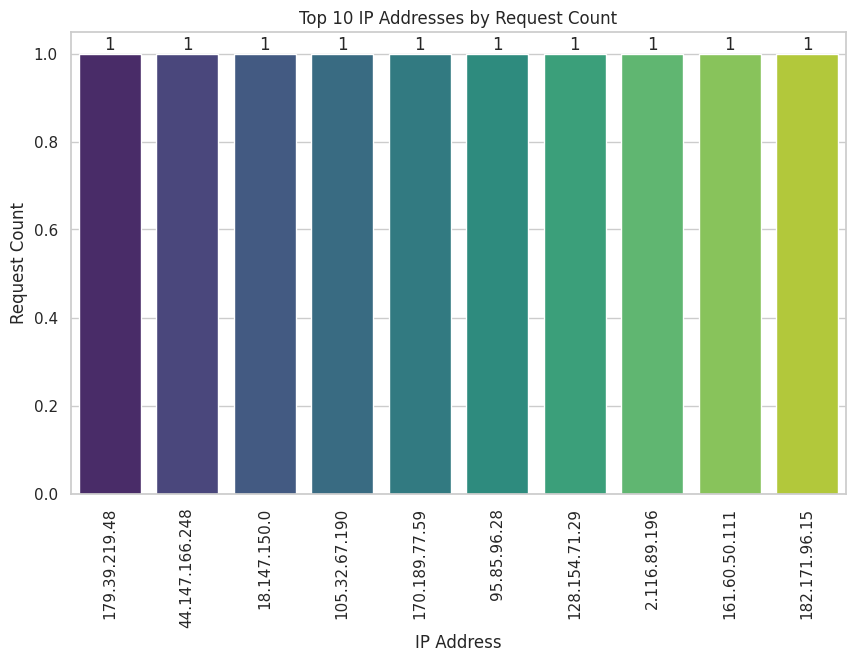

<ipython-input-41-d0cb0990769f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=methods, y=method_counts, palette='coolwarm')


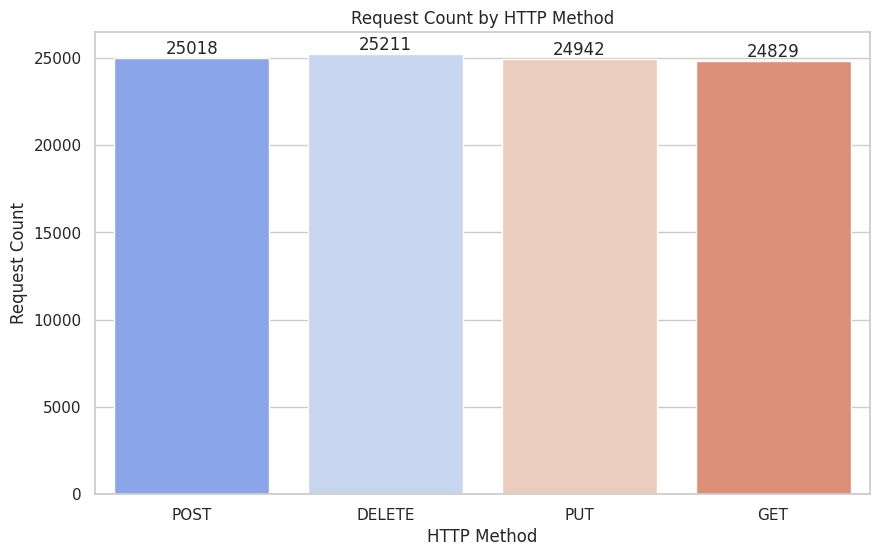

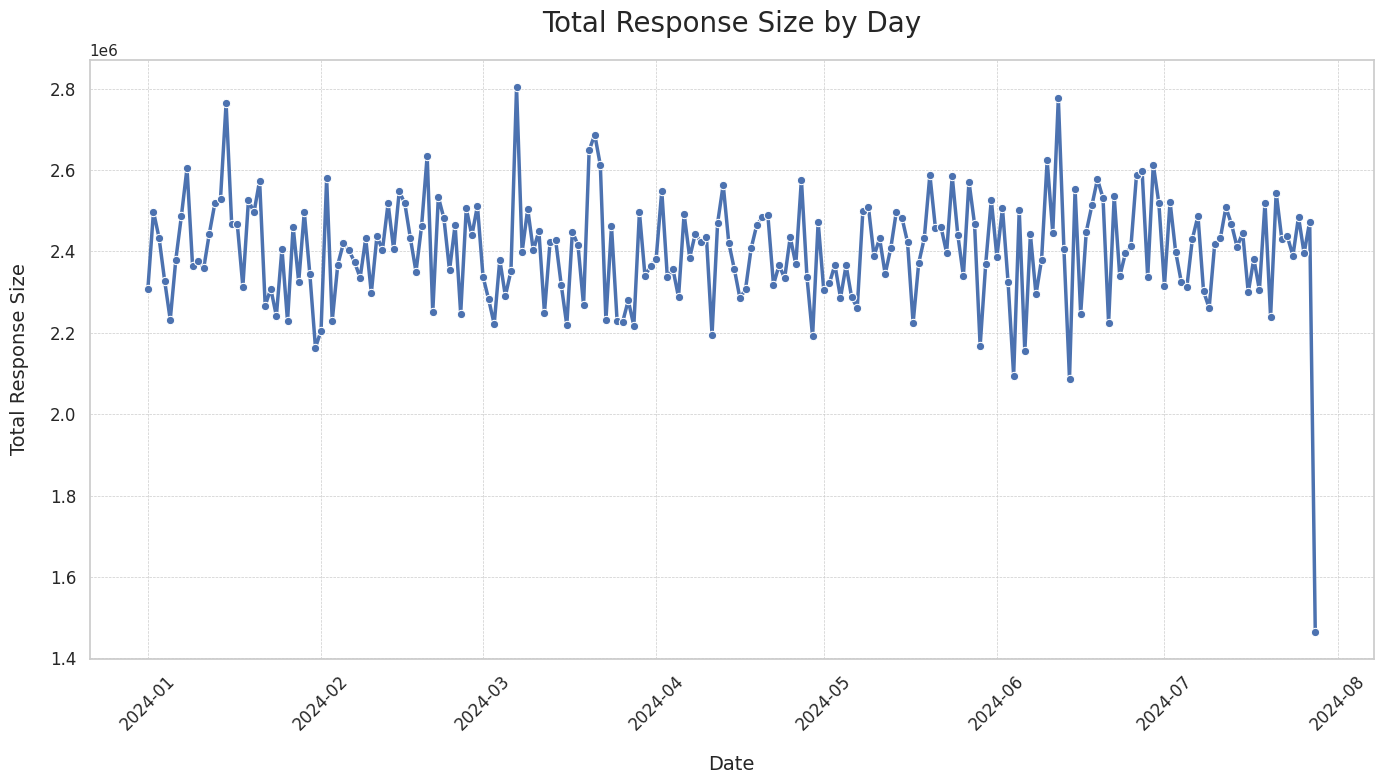

In [ ]:
# топ 10 IP адресов по количеству запросов
ips = [row['ip'] for row in top10_IP_addresses_data]
request_counts = [row['request_count'] for row in top10_IP_addresses_data]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=ips, y=request_counts, palette='viridis')
plt.title('Top 10 IP Addresses by Request Count')
plt.xlabel('IP Address')
plt.ylabel('Request Count')
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xticks(rotation=90)
plt.show()

# количество запросов для каждого HTTP метода
methods = [row['method'] for row in request_count_by_HTTP_method_data]
method_counts = [row['method_count'] for row in request_count_by_HTTP_method_data]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=methods, y=method_counts, palette='coolwarm')
plt.title('Request Count by HTTP Method')
plt.xlabel('HTTP Method')
plt.ylabel('Request Count')
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.show()


# сумма response_size по датам
dates = [row['date'] for row in total_response_size_data]
total_sizes = [row['total_response_size'] for row in total_response_size_data]

plt.figure(figsize=(14, 8))
sns.set(style='whitegrid')
ax = sns.lineplot(x=dates, y=total_sizes, marker='o', color='b', linewidth=2.5)
plt.title('Total Response Size by Day', fontsize=20, pad=20)
plt.xlabel('Date', fontsize=14, labelpad=15)
plt.ylabel('Total Response Size', fontsize=14, labelpad=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
